# Forecast delle vendite con variabili esogene
Questo notebook mostra un esempio didattico di previsione delle vendite utilizzando modelli di machine learning. Include variabili esogene come promozioni, prezzo e temperatura, e confronta modelli diversi (Ridge e XGBoost).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

## 1. Simulazione dei dati
Simuliamo dati giornalieri per 3 anni, con vendite influenzate da fattori esogeni come promozioni, prezzo e temperatura.

In [2]:
np.random.seed(42)
date_range = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')
n = len(date_range)

base_sales = 200 + 10 * np.sin(2 * np.pi * date_range.dayofyear / 365)
promo = np.random.binomial(1, 0.1, size=n)
price = 10 + np.random.normal(0, 0.5, size=n)
temperature = 15 + 10 * np.sin(2 * np.pi * (date_range.dayofyear + 50) / 365) + np.random.normal(0, 2, size=n)

sales = base_sales + promo * 40 - price * 5 + temperature * 1.5 + np.random.normal(0, 10, size=n)

df = pd.DataFrame({
    'date': date_range,
    'sales': sales,
    'promo': promo,
    'price': price,
    'temperature': temperature
})
df.set_index('date', inplace=True)

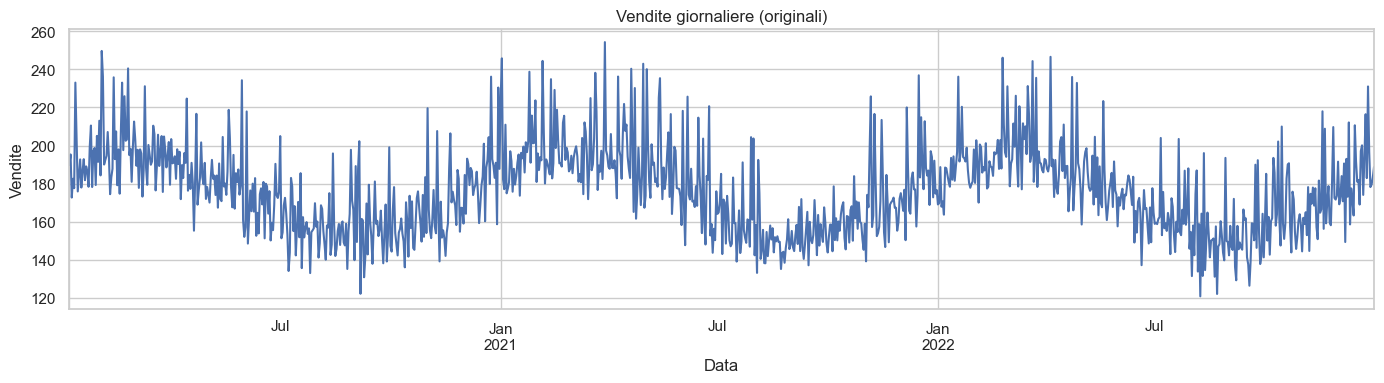

In [21]:
plt.figure(figsize=(14, 4))
df['sales'].plot()
plt.title("Vendite giornaliere (originali)")
plt.xlabel("Data")
plt.ylabel("Vendite")
plt.tight_layout()
plt.show()

## 2. Feature Engineering
Creiamo nuove variabili da usare come input: informazioni temporali, valori lag e medie mobili.

In [3]:
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['lag_1'] = df['sales'].shift(1)
df['rolling_mean_7'] = df['sales'].rolling(window=7).mean()
df['rolling_std_7'] = df['sales'].rolling(window=7).std()
df = df.dropna()

<Figure size 1400x400 with 0 Axes>

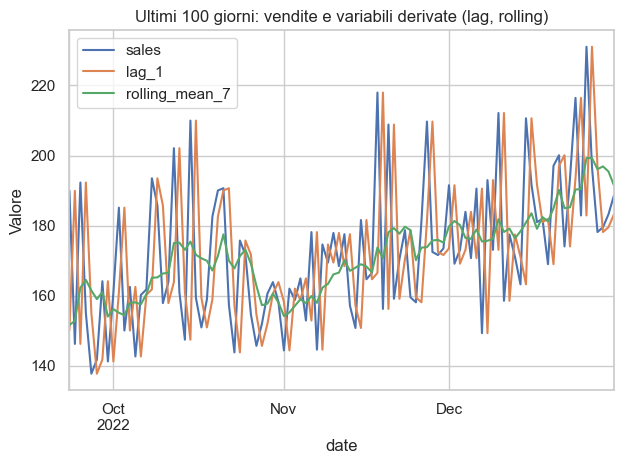

In [22]:
plt.figure(figsize=(14, 4))
df[['sales', 'lag_1', 'rolling_mean_7']].iloc[-100:].plot()
plt.title("Ultimi 100 giorni: vendite e variabili derivate (lag, rolling)")
plt.ylabel("Valore")
plt.tight_layout()
plt.show()

## 3. Train/Test Split
Suddividiamo il dataset in un set di addestramento e uno di test basandoci sull'ordine temporale.

In [4]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

features = ['promo', 'price', 'temperature', 'dayofweek', 'month', 'lag_1', 'rolling_mean_7', 'rolling_std_7']
X_train = train[features]
y_train = train['sales']
X_test = test[features]
y_test = test['sales']

## 4. Standardizzazione delle feature
Applichiamo lo scaling alle feature per modelli sensibili alla scala, come Ridge.

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Regressione Ridge
Utilizziamo una regressione lineare con regolarizzazione L2 (Ridge).

In [6]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
print(f'MAE Ridge: {mae_ridge:.2f}')

MAE Ridge: 7.53


## 6. XGBoost Regressor
Modello di boosting gradientale, efficace con dati tabellari e non lineari.

In [7]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f'MAE XGBoost: {mae_xgb:.2f}')

MAE XGBoost: 8.19


## 7. Visualizzazione dei risultati
Confrontiamo graficamente le previsioni di entrambi i modelli con le vendite reali.

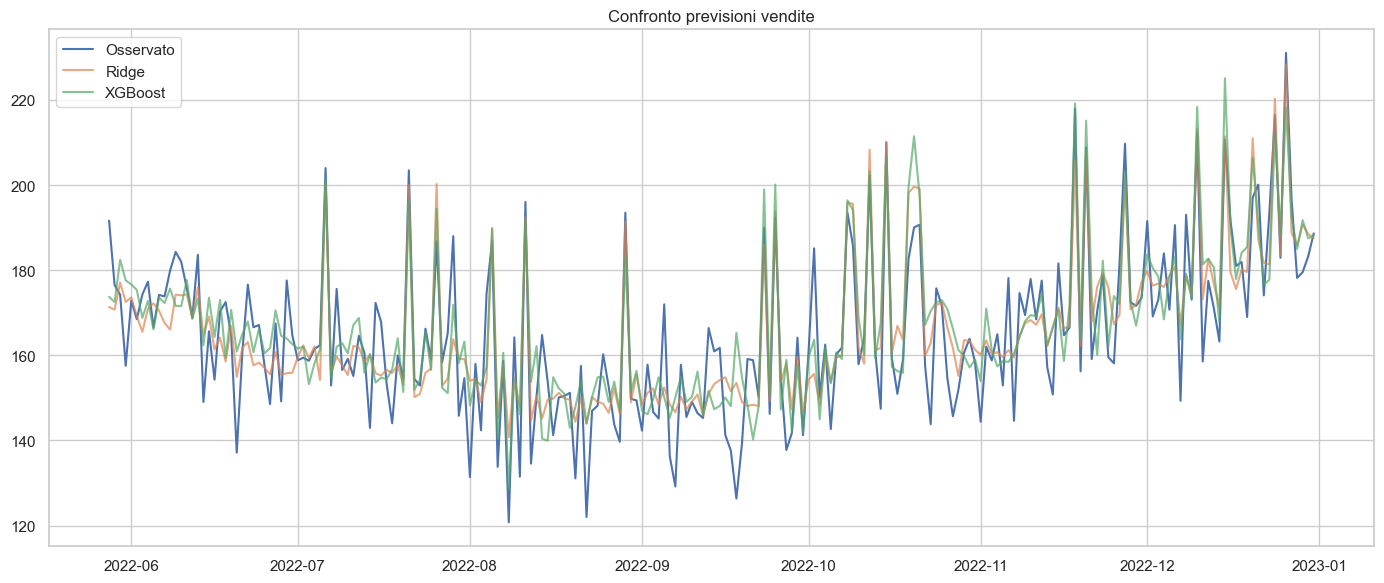

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Osservato')
plt.plot(y_test.index, y_pred_ridge, label='Ridge', alpha=0.7)
plt.plot(y_test.index, y_pred_xgb, label='XGBoost', alpha=0.7)
plt.title('Confronto previsioni vendite')
plt.legend()
plt.tight_layout()
plt.show()

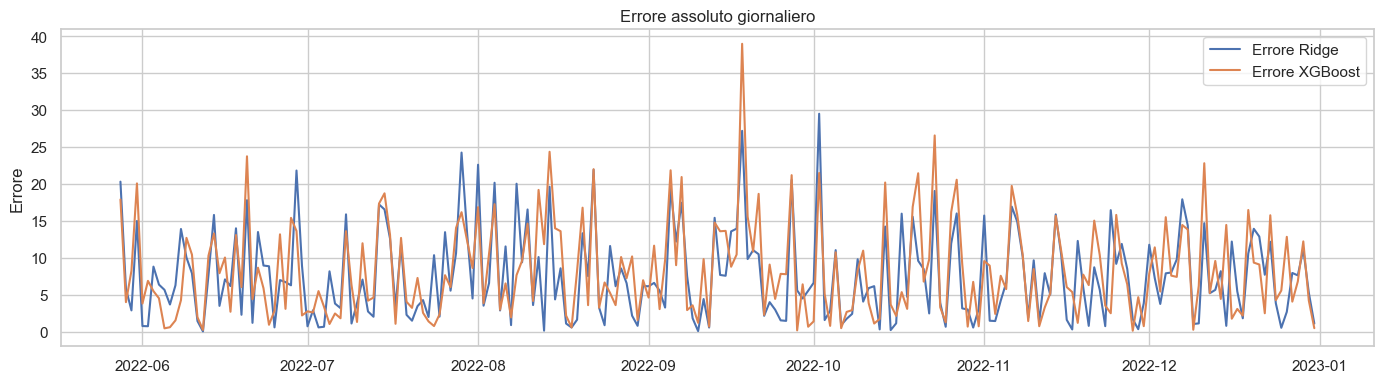

In [10]:
plt.figure(figsize=(14, 4))
plt.plot(y_test.index, np.abs(y_test - y_pred_ridge), label="Errore Ridge")
plt.plot(y_test.index, np.abs(y_test - y_pred_xgb), label="Errore XGBoost")
plt.title("Errore assoluto giornaliero")
plt.ylabel("Errore")
plt.legend()
plt.tight_layout()
plt.show()

## 8. Reti neurali semplici (Deep Learning)
Ora applichiamo una rete neurale feedforward semplice con Keras per confrontare le performance con i modelli precedenti. Questo approccio è utile per catturare non linearità complesse nelle relazioni tra feature e target.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
# Creazione modello MLP semplice
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

In [16]:
# Addestramento
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stop], verbose=0)

In [17]:
# Valutazione e predizione
y_pred_dl = model.predict(X_test_scaled).flatten()
mae_dl = mean_absolute_error(y_test, y_pred_dl)
print(f'MAE Rete Neurale: {mae_dl:.2f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MAE Rete Neurale: 8.37


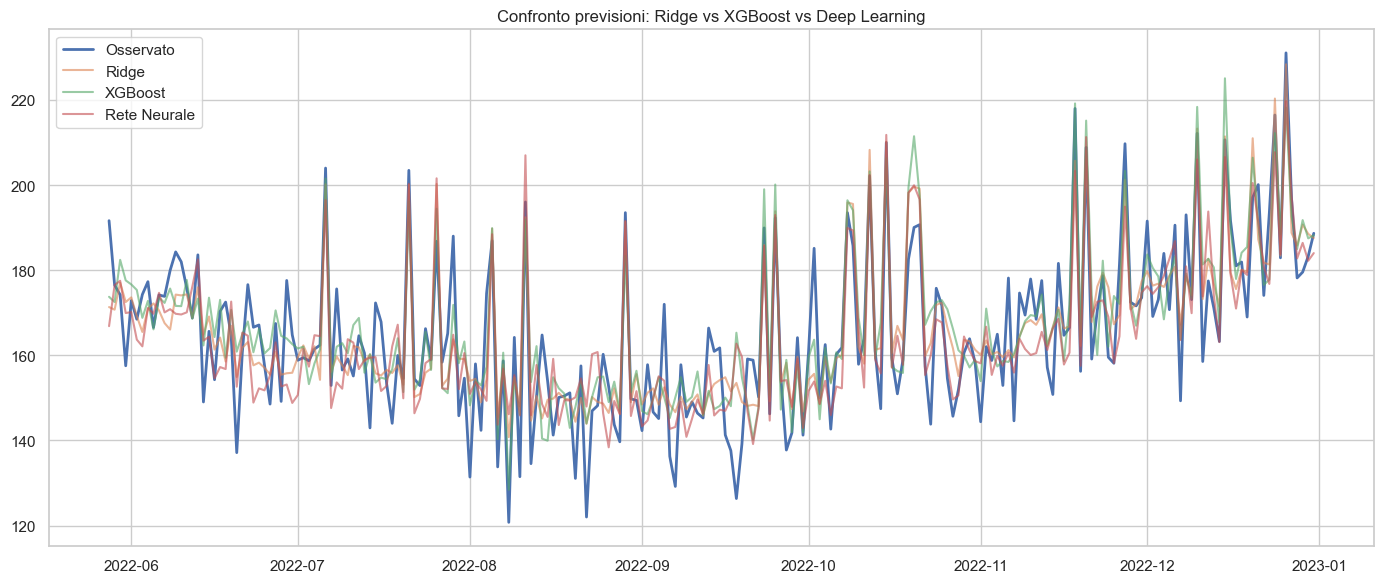

In [20]:
# Confronto grafico con i modelli precedenti
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Osservato', linewidth=2)
plt.plot(y_test.index, y_pred_ridge, label='Ridge', alpha=0.6)
plt.plot(y_test.index, y_pred_xgb, label='XGBoost', alpha=0.6)
plt.plot(y_test.index, y_pred_dl, label='Rete Neurale', alpha=0.6)
plt.title('Confronto previsioni: Ridge vs XGBoost vs Deep Learning')
plt.legend()
plt.tight_layout()
plt.show()